In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import umap
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

from functions.common_functions import *

In [2]:
df = pd.read_csv('../data/processed/CPA-virtual_database.csv')
df_training = df[df['Rxn_Type'] == 'Training']
df_training_rxns = df_training['rxn']
df_virtual = df[df['Rxn_Type'] == 'Virtual']
df_virtual = df_virtual[df_virtual['Catalyst_Ar_grp'] == 'L15']
df_virtual = df_virtual.reset_index(drop=True)

In [3]:
## Initial Processing ##

vt = VarianceThreshold()

parameters = df_virtual.iloc[:,9:] ## Set parameters to desired columns ##
thres = vt.fit(parameters)
parameters = thres.transform(parameters)

scaled_data = StandardScaler().fit_transform(parameters)

## Clustering Embedding ##

num_reactions = len(df_virtual)

reducer = umap.UMAP(
    random_state=25,
    min_dist=0,  # Default is 0.1
    n_neighbors=num_reactions/2,  # Default is 15
    n_components=10)

clustering_embedding = reducer.fit_transform(scaled_data)

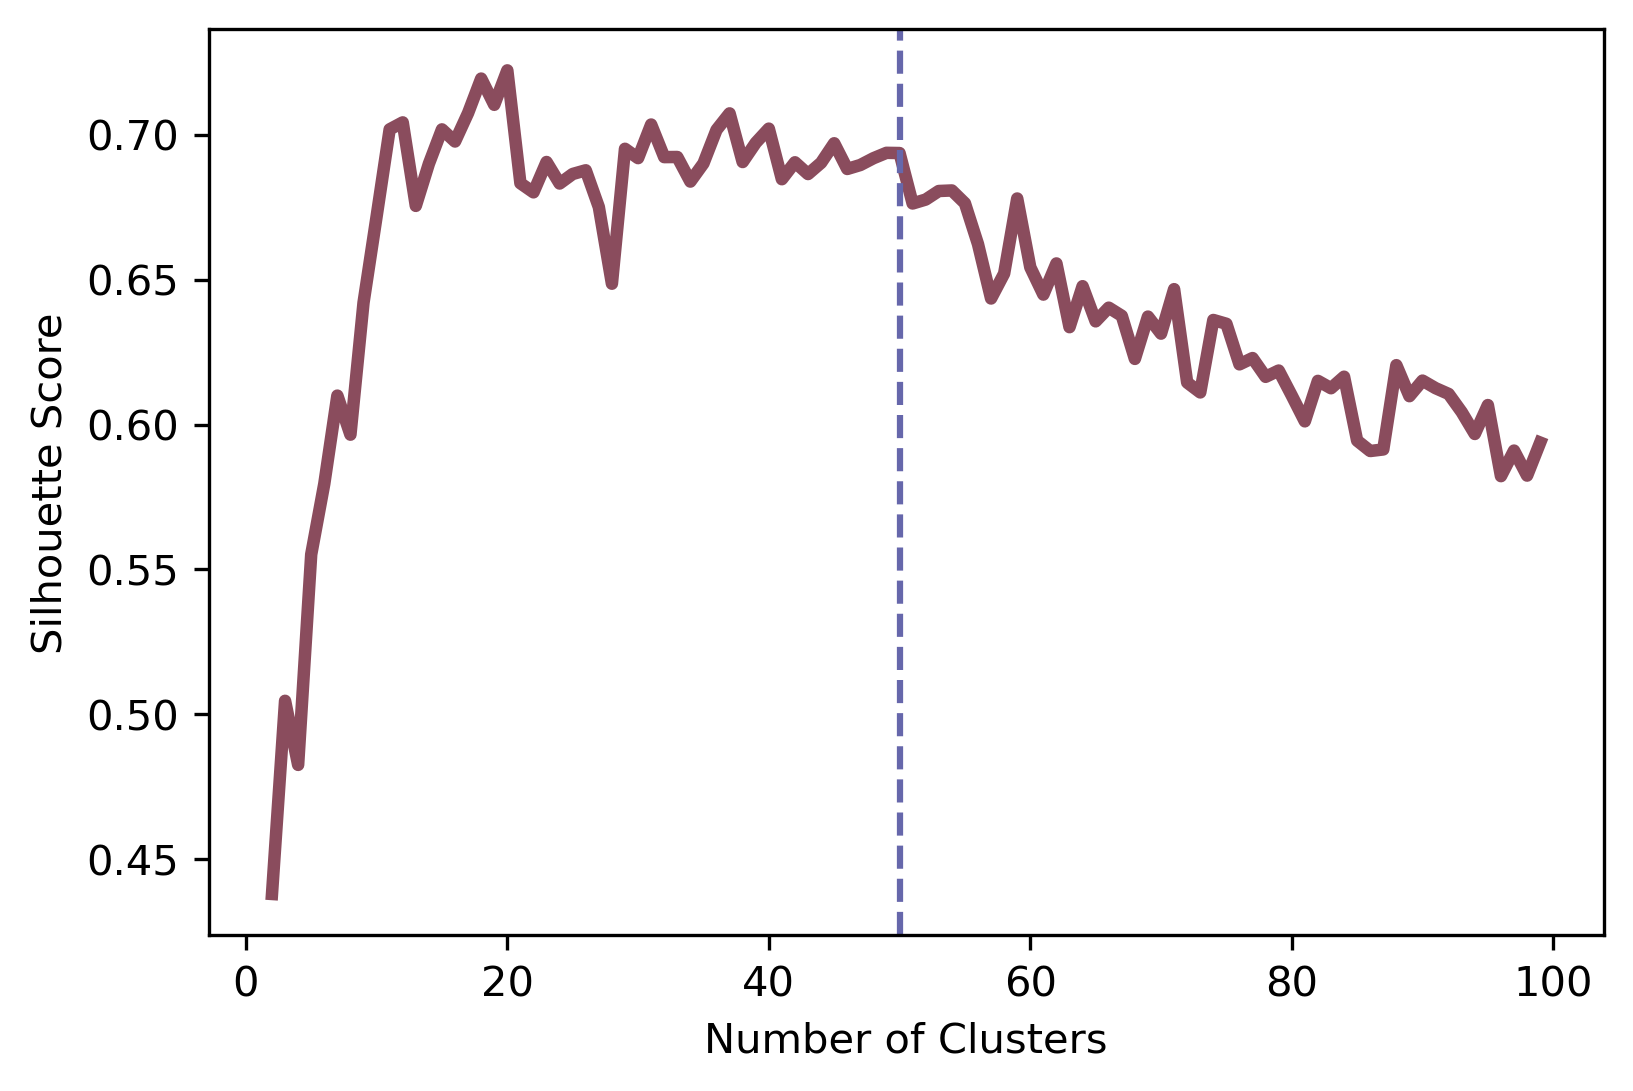

In [5]:
## Silhouette Analysis ##
silhouette_vals = []
num_clusters = range(2,100)

for cluster in num_clusters:
    kmeans = KMeans(
        init="k-means++",
        n_clusters=cluster,
        n_init=10,
        max_iter=300,
        random_state=25
        )
    clustering = kmeans.fit(clustering_embedding)
    silhouette_vals.append(silhouette_score(clustering_embedding,clustering.labels_))

fig, ax = plt.subplots()
fig.set_dpi(300)
plt.plot(num_clusters,silhouette_vals, color='#8a4c5d', linewidth=3)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
# plt.xticks([0,5,10,15,20])
ax.axvline(x=50, color="#6667ab", linestyle="--")

plt.show()


In [ ]:
for n_clusters in num_clusters:
    fig, ax1 = plt.subplots()
    fig.set_dpi(150)


    ax1.set_xlim([-0.2, 1])

    ax1.set_ylim([0, len(clustering_embedding) + (n_clusters + 1) * 10])

    clusterer = KMeans(
                init="k-means++",
                n_clusters=n_clusters,
                n_init=10,
                max_iter=300,
                random_state=25
                )
    cluster_labels = clusterer.fit(clustering_embedding).labels_

    silhouette_avg = silhouette_score(clustering_embedding, cluster_labels)

    sample_silhouette_values = silhouette_samples(clustering_embedding, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.gist_earth(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )


        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for " + str(n_clusters) + " clusters")
    ax1.set_xlabel("Silhouette Values")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  